/var/folders/qv/qpqwspdx2mn4zndqj91cxnkwzfytzl/T/ipykernel_10986/2111672081.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


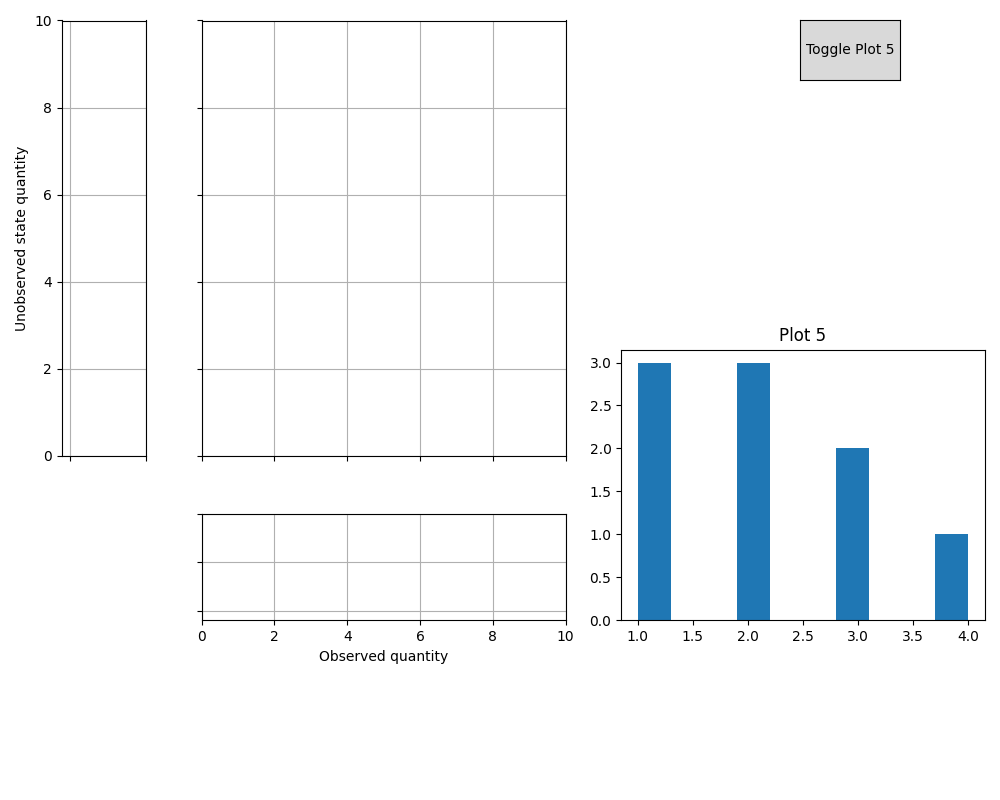

18

Clicked at x=2.5413657713392706, y=3.87472885032538
Clicked at x=4.43760067414469, y=4.908287610054868
Clicked at x=6.608652229530607, y=5.941846369784357
Clicked at x=6.965913877885251, y=8.284579558504529
Clicked at x=7.9827354924330844, y=7.756316192420569
Clicked at x=4.052857360531997, y=0.36062906724512
Clicked at x=5.014715644563731, y=2.8871060354727573
Clicked at x=8.010217157691134, y=4.173312492025009


In [115]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Button
import numpy as np
%matplotlib widget

# Create figure
fig = plt.figure(figsize=(10, 8))

# Define GridSpec
gs = gridspec.GridSpec(5, 7, figure=fig)

# Create subplots of varying sizes and shapes
ax1 = fig.add_subplot(gs[0:3, 1:4]) # clicky main plot
ax2 = fig.add_subplot(gs[3, 1:4])   # Observered quantity
ax3 = fig.add_subplot(gs[0:3, 0])   # Unobserved state quantity
ax5 = fig.add_subplot(gs[2:4, 4:7]) # Marginal Distristribution of observation


# Customize each subplot
ax1.grid(True)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax2.set_xlabel('Observed quantity')
ax2.grid(True)

ax3.set_ylabel('Unobserved state quantity')
ax3.grid(True)

# Get the limits of ax1
x_limits_ax1 = ax1.get_xlim()
y_limits_ax1 = ax1.get_ylim()

# Set the limits of ax2, ax3 to match those of ax1
ax2.set_xlim(x_limits_ax1)
ax2.set_ylim(-0.1, 1)
ax2.set_yticklabels([])

ax3.set_xlim(-0.1, 1)
ax3.set_ylim(y_limits_ax1)
ax3.set_xticklabels([])


ax5.hist([1, 2, 1, 2, 3, 4, 3, 2, 1])
ax5.set_title('Plot 5')

# Create a button axes
button_ax = plt.axes([0.8, 0.9, 0.1, 0.075])  # Adjust the position and size as needed
button = Button(button_ax, 'Toggle Plot 5')

# Define the event handler
def update_ensemble(event):
    ax5.set_visible(not ax5.get_visible())
    # Use zip and the * operator to unzip the list of tuples into two lists
    x_list, y_list = zip(*clicked_points)

    # Convert the tuples to lists 
    x_list = list(x_list)
    y_list = list(y_list)

    # plot the best fit line
    # Calculate the best fit line parameters: slope (m) and intercept (b)
    m, b = np.polyfit(x_list, y_list, 1)  # 1 means linear (first-degree polynomial)

    # Generate x values for the line: from the minimum to the maximum x value in clicked_points
    x_line = np.linspace(0, 10, 100)  # 100 points for a smooth line

    # Calculate corresponding y values based on the line equation y = mx + b
    y_line = m * x_line + b

    # Plot the line on ax1 (or any other subplot as needed)
    ax1.plot(x_line, y_line, 'g-', label='Best Fit Line')  # 'r-' for a red line

    # this is a stand in for the ensemble kalman filter update
    updated_x = [x+0.5 for x in x_list]
    updated_y = [y+0.5 for y in y_list]

    ax1.plot(updated_x, updated_y, 'b*')  # Plot the updated points
    z = [0.1] * len(updated_x) 
    dz = 1 / (len(updated_x) +1)
    z_plot = [element + dz*i for i, element in enumerate(z)]
    
    # plot updated points on marginals
    ax2.plot(updated_x, z_plot, 'b*')
    ax3.plot(z_plot, updated_y, 'b*')

    # plot increment lines
    for i, _ in enumerate(updated_x):
        ax2.plot([x_list[i], updated_x[i]], [z_plot[i], z_plot[i]], 'b-')
        ax3.plot([z_plot[i], z_plot[i]], [y_list[i], updated_y[i]], 'b-')

    plt.draw()  # Redraw the figure to reflect changes

# Connect the event handler
button.on_clicked(update_ensemble)

plt.tight_layout()
plt.show()

# Initialize an empty list to store the points
clicked_points = []

def on_click(event):
    # Check if the click was on ax1
    if event.inaxes == ax1:
        # Append the clicked point (xdata, ydata) to the list
        clicked_points.append((event.xdata, event.ydata))
        print(f"Clicked at x={event.xdata}, y={event.ydata}")
        # Plot the click coordinates on ax1
        ax1.plot(event.xdata, event.ydata, 'go')  # 'ro' plots a red dot
        ax2.plot(event.xdata, 0, 'g*')
        ax3.plot(0, event.ydata, 'g*')
        plt.draw()  # Update the plot with the new point

# Connect the event handler to the figure
fig.canvas.mpl_connect('button_press_event', on_click)


In [116]:
clicked_points

[]